# Implementation of Age Detection

## Importing Librabries

In [3]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.0 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
from scipy.io import loadmat
import pandas as pd
from mtcnn import MTCNN

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz /content/


--2024-03-11 20:02:43--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3157487479 (2.9G) [application/x-gzip]
Saving to: ‘wiki.tar.gz’

wiki.tar.gz         100%[===================>]   2.94G  93.5MB/s    in 40s     

2024-03-11 20:03:24 (74.7 MB/s) - ‘wiki.tar.gz’ saved [3157487479/3157487479]

/content/: Scheme missing.
FINISHED --2024-03-11 20:03:24--
Total wall clock time: 41s
Downloaded: 1 files, 2.9G in 40s (74.7 MB/s)


In [ ]:
# !tar -xzvf "/content/wiki.tar.gz" -C "/content/"

In [6]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.5 MB/s eta 0:00:00


In [7]:
#setup creditials for mlflow
import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

Enter your DAGsHub username: rachana
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: age_detection


username:: rachana


token:c90d6e849df9e5f5024decdde31d82dd4a85619a
project name: age_detection

In [8]:
#auto track in mlflow
mlflow.tensorflow.autolog()

## Data Collection and Transforamtion from mat file to dataframe

In [ ]:
# # Load the .mat file
# mat = loadmat('/content/wiki/wiki.mat')
# # Converting into pandas dataframe
# instances = mat['wiki'][0][0][0].shape[1]

# columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# df = pd.DataFrame(index=range(0, instances), columns=columns)

# for i in mat:
#     if i == "wiki":
#         current_array = mat[i][0][0]

# for j in range(len(current_array)):
#     df[columns[j]] = pd.DataFrame(current_array[j][0])
# df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN
...,...,...,...,...,...,...,...,...
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.029268,NaN
62324,711338,1970,[32/9997032_1947-07-30_1970.jpg],1.0,[Nico Rijnders],"[[1, 1, 285, 440]]",-inf,NaN
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.494303,NaN
62326,723893,2011,[00/9999400_1981-12-13_2011.jpg],1.0,[Johann Grugger],"[[1, 1, 1, 1]]",-inf,NaN


In [18]:
import pandas as pd

# Path to the Excel file
excel_file_path = '/content/drive/MyDrive/Rachana/meta 3 (2).xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file_path)

# Display the DataFrame
print(df)


       age  gender                          path  face_score1  face_score2
0       39    male   4256472_1974-08-10_2014.jpg     2.065577          NaN
1       44  female    705751_1968-02-12_2013.jpg     2.679429          NaN
2       18    male  21153567_1991-02-25_2010.jpg     3.335584          NaN
3       52    male   3649107_1957-11-07_2010.jpg     4.233472          NaN
4       33  female   1421957_1973-12-05_2007.jpg     4.684032          NaN
...    ...     ...                           ...          ...          ...
62323   31  female  30408996_1977-06-25_2009.jpg     2.215920          NaN
62324   59    male    147311_1930-09-23_1990.jpg     1.147500          NaN
62325   27    male   3860006_1972-08-03_2000.jpg          NaN          NaN
62326   25    male  21547067_1983-09-18_2009.jpg     3.731897          NaN
62327   26  female  16173936_1982-08-31_2009.jpg     2.489738          NaN

[62328 rows x 5 columns]


In [19]:
df['full_path'] = [str('/content/drive/MyDrive/Rachana/cropped_faces/')+str(np.squeeze(i)) for i in df['path']]
df

df.head()

,age,gender,path,face_score1,face_score2,full_path
0,39,male,4256472_1974-08-10_2014.jpg,2.065577,NaN,/content/drive/MyDrive/Rachana/cropped_faces/4...
1,44,female,705751_1968-02-12_2013.jpg,2.679429,NaN,/content/drive/MyDrive/Rachana/cropped_faces/7...
2,18,male,21153567_1991-02-25_2010.jpg,3.335584,NaN,/content/drive/MyDrive/Rachana/cropped_faces/2...
3,52,male,3649107_1957-11-07_2010.jpg,4.233472,NaN,/content/drive/MyDrive/Rachana/cropped_faces/3...
4,33,female,1421957_1973-12-05_2007.jpg,4.684032,NaN,/content/drive/MyDrive/Rachana/cropped_faces/1...


In [ ]:
# # Sort the DataFrame in ascending order based on the "photo_taken" column
# df_sorted = df.sort_values(by='full_path', ascending=True)
# len(df_sorted.index)

In [ ]:
# df_sorted

In [ ]:
# # # Select only the first 19626 rows
# # df_selected = df_sorted.head(5000)
# # len(df_selected.index)
# # df_selected = df.iloc[5000:10000+1]
# # df_selected = df.iloc[5000:15001]  # Select rows 5001 to 15000 (inclusive)
# # len(df_selected)
# # # Select rows 15001 to 25000
# # df_selected = df.iloc[15000:20000]

# # # Check the length of the selected DataFrame
# # len(df_selected.index)
# # df_selected = df.iloc[20000:25000]
# # len(df_selected.index)

# # df_selected = df.iloc[25000:30000]
# # len(df_selected.index)


# # df_selected = df.iloc[30000:35000]
# # len(df_selected.index)


# df_selected = df.iloc[40000:62328+1]
# len(df_selected.index)

In [10]:
# # Update the original DataFrame with the selected rows
# df = df_selected.copy()

# # Optionally, reset the index
# df.reset_index(drop=True, inplace=True)

# # Display the updated DataFrame
# print(df)

## Data Cleaning and Preprocessing

In [20]:
# # Extracting Year from DOB
# from datetime import datetime, timedelta

# def datenum_to_datetime(datenum):
#     days = datenum % 1
#     hours = days % 1 * 24
#     minutes = hours % 1 * 60
#     seconds = minutes % 1 * 60
#     exact_date = datetime.fromordinal(int(datenum)) + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
#                  + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) - timedelta(days=366)

#     return exact_date.year

# df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

# # Getting present age from dob and photo taken columns
# df['age'] = df['photo_taken'] - df['date_of_birth']

# Remove pictures that do not include a face
df = df[df['face_score1'] != -np.inf]

# Remove pictures that include more than one face
df = df[df['face_score2'].isna()]

# Remove ages greater than 65
df = df[df['age'] <= 65]

# Remove ages less than 20
df = df[df['age'] >= 20]

# Lower threshold for face_score to allow more images of poor quality
df = df[df['face_score1'] >= 1.75]
df = df.drop(columns=['face_score1', 'face_score2'])
df

,age,gender,path,full_path
0,39,male,4256472_1974-08-10_2014.jpg,/content/drive/MyDrive/Rachana/cropped_faces/4...
1,44,female,705751_1968-02-12_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/7...
3,52,male,3649107_1957-11-07_2010.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...
4,33,female,1421957_1973-12-05_2007.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...
5,29,female,33235439_1983-05-08_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...
...,...,...,...,...
62318,25,male,14539522_1982-05-26_2008.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...
62320,23,male,31219748_1989-09-04_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...
62323,31,female,30408996_1977-06-25_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...
62326,25,male,21547067_1983-09-18_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/2...


In [21]:
# Defining a function to return the class labels corresponding to the re-distributed 9 age-ranges.

def class_labels_reassign(age):

    if 20 <= age <25:
        return 0
    elif 25 <= age < 30:
        return 1
    elif 30 <= age < 35:
        return 2
    elif 35 <= age < 40:
        return 3
    elif 40 <= age < 45:
        return 4
    elif 45 <= age < 50:
        return 5
    elif 50 <= age < 55:
        return 6
    elif 55 <= age < 60:
        return 7
    else:
        return 8
df['ageclass'] = df['age'].map(class_labels_reassign)
df

,age,gender,path,full_path,ageclass
0,39,male,4256472_1974-08-10_2014.jpg,/content/drive/MyDrive/Rachana/cropped_faces/4...,3
1,44,female,705751_1968-02-12_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/7...,4
3,52,male,3649107_1957-11-07_2010.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,6
4,33,female,1421957_1973-12-05_2007.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...,2
5,29,female,33235439_1983-05-08_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,1
...,...,...,...,...,...
62318,25,male,14539522_1982-05-26_2008.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...,1
62320,23,male,31219748_1989-09-04_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,0
62323,31,female,30408996_1977-06-25_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,2
62326,25,male,21547067_1983-09-18_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/2...,1


In [ ]:
# !pip uninstall opencv-python -y
# !pip uninstall opencv-contrib-python -y

Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80
Found existing installation: opencv-contrib-python 4.9.0.80
Uninstalling opencv-contrib-python-4.9.0.80:
  Successfully uninstalled opencv-contrib-python-4.9.0.80


In [22]:
!pip install opencv-contrib-python

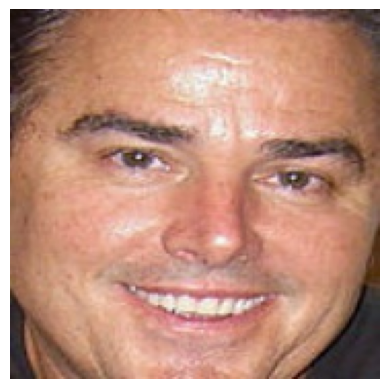

In [23]:
# Assuming you want to display the image of the first face in the DataFrame
import cv2
from matplotlib import pyplot as plt

image_path = df['full_path'].iloc[2]

# Load the image using cv2
image = cv2.imread(image_path)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers
plt.show()


In [ ]:
# detector = MTCNN()
# # Function to crop the face from the image
# def crop_face(image_path):
#     try:
#         img = cv2.imread(image_path)
#         if img is None:
#             return None
#         faces = detector.detect_faces(img)
#         if faces and faces[0]['confidence'] > 0.98:
#             x, y, w, h = faces[0]['box']
#             cropped_face = img[y:y+h, x:x+w]
#             # Resize the cropped face to 180x180 and convert to RGB
#             cropped_face = cv2.resize(cropped_face, (180, 180))
#             cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
#             return cropped_face
#         else:
#             return None
#     except Exception as e:
#         print(f"Error processing image: {image_path}")
#         print(e)
#         return None

# # Process images in batches
# batch_size = 100
# num_batches = len(df) // batch_size
# for i in range(num_batches + 1):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, len(df))
#     df_batch = df.iloc[start_idx:end_idx]
#     df_batch['cropped_face'] = df_batch['path'].apply(crop_face)
#     # Save or process the cropped faces as needed

# # Save the processed data
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/cropped_faces_processed_data.csv', index=False)

In [ ]:
# # Function to crop the face from the image
# def crop_face(image_path):
#     img = cv2.imread(f'{image_path}')
#     if img is None:
#         return None
#     detector = MTCNN()
#     faces = detector.detect_faces(img)
#     if faces and faces[0]['confidence'] > 0.98:
#         x, y, w, h = faces[0]['box']
#         cropped_face = img[y:y+h, x:x+w]
#         # Resize the cropped face to 180x180 and convert to RGB
#         cropped_face = cv2.resize(cropped_face, (180, 180))
#         cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
#         return cropped_face
#     else:
#         return None

# # Apply face cropping to all images
# df['cropped_face'] = df['path'].apply(crop_face)



In [ ]:
# import tensorflow as tf

# detector = MTCNN()

# @tf.function
# def crop_face(image_path):
#     img = cv2.imread(f'{image_path}')
#     if img is None:
#         return None
#     faces = detector.detect_faces(img)
#     if faces and faces[0]['confidence'] > 0.98:
#         x, y, w, h = faces[0]['box']
#         cropped_face = img[y:y+h, x:x+w]
#         # Resize the cropped face to 180x180 and convert to RGB
#         cropped_face = cv2.resize(cropped_face, (180, 180))
#         cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
#         return cropped_face
#     else:
#         return None

# # Apply face cropping to all images
# df['cropped_face'] = df['path'].apply(crop_face)


In [ ]:
# import os

# output_dir = '/content/drive/MyDrive/models/cropped_faces/'
# os.makedirs(output_dir, exist_ok=True)

# detector = MTCNN()

# def crop_face(image_path, output_dir):
#     img = cv2.imread(f'{image_path}')
#     if img is None:
#         return None

#     faces = detector.detect_faces(img)
#     if faces:
#         x, y, w, h = faces[0]['box']
#         cropped_face = img[y:y+h, x:x+w]
#         # Resize the cropped face to 180x180 and convert to RGB
#         cropped_face = cv2.resize(cropped_face, (180, 180))
#         cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

#         # Save the cropped face
#         filename = os.path.basename(image_path)
#         output_path = os.path.join(output_dir, filename)
#         cv2.imwrite(output_path, cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))

#         return output_path
#     else:
#         return None

# # Apply face cropping to all images
# df['cropped_face_path'] = df['path'].apply(lambda x: crop_face(x, output_dir))

# # Display the dataframe
# df.head()


In [ ]:
# import os
# import cv2
# import pandas as pd

# # Path to the directory containing cropped face images
# cropped_face_dir = '/content/drive/MyDrive/models/cropped_faces'

# # Load images, resize, and convert to RGB
# def load_resize_image(image_path):
#     img = cv2.imread(image_path)
#     if img is None:
#         return None
#     #resized_img = cv2.resize(img, (180, 180))
#     #rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     return img

# # Apply the function to each row in the DataFrame
# df['cropped_face'] = df['full_path'].apply(lambda x: load_resize_image(os.path.join(cropped_face_dir, x)))

# # Display the DataFrame
# print(df.head())


In [24]:
df

,age,gender,path,full_path,ageclass
0,39,male,4256472_1974-08-10_2014.jpg,/content/drive/MyDrive/Rachana/cropped_faces/4...,3
1,44,female,705751_1968-02-12_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/7...,4
3,52,male,3649107_1957-11-07_2010.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,6
4,33,female,1421957_1973-12-05_2007.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...,2
5,29,female,33235439_1983-05-08_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,1
...,...,...,...,...,...
62318,25,male,14539522_1982-05-26_2008.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...,1
62320,23,male,31219748_1989-09-04_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,0
62323,31,female,30408996_1977-06-25_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,2
62326,25,male,21547067_1983-09-18_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/2...,1


## EDA (Exploratory Data Analysis)

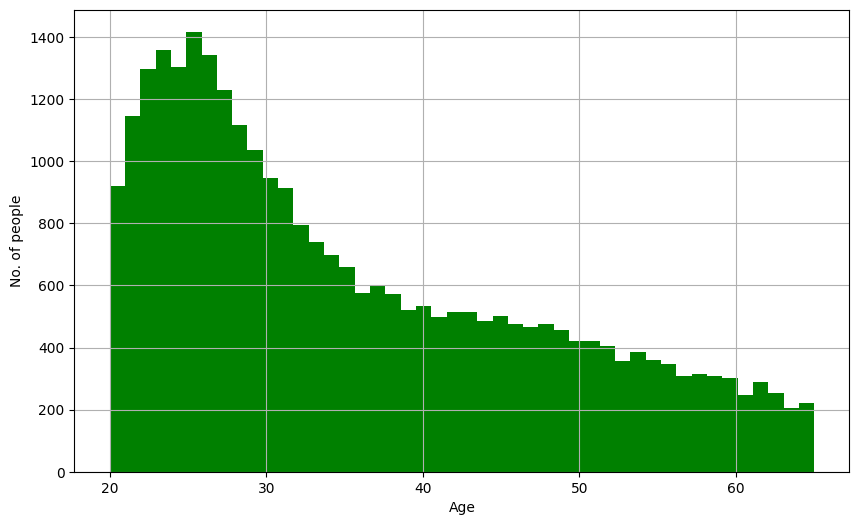

In [25]:
#Distibution of number of people based on ages
df['age'].hist(bins=df['age'].nunique(),color='g',figsize=(10,6))

plt.xlabel('Age')
plt.ylabel('No. of people')
plt.show()

In [26]:
x = (df.ageclass==0).sum()
y = (df.ageclass==1).sum()
z = (df.ageclass==2).sum()
a = (df.ageclass==3).sum()
b = (df.ageclass==4).sum()
c = (df.ageclass==5).sum()
d = (df.ageclass==6).sum()
e = (df.ageclass==7).sum()
f = (df.ageclass==8).sum()
print(x,' ',y,' ',z,' ',a,' ',b, ' ',c,' ',d,' ',e,' ',f)

6023   6143   4090   2927   2545   2376   1987   1638   1518


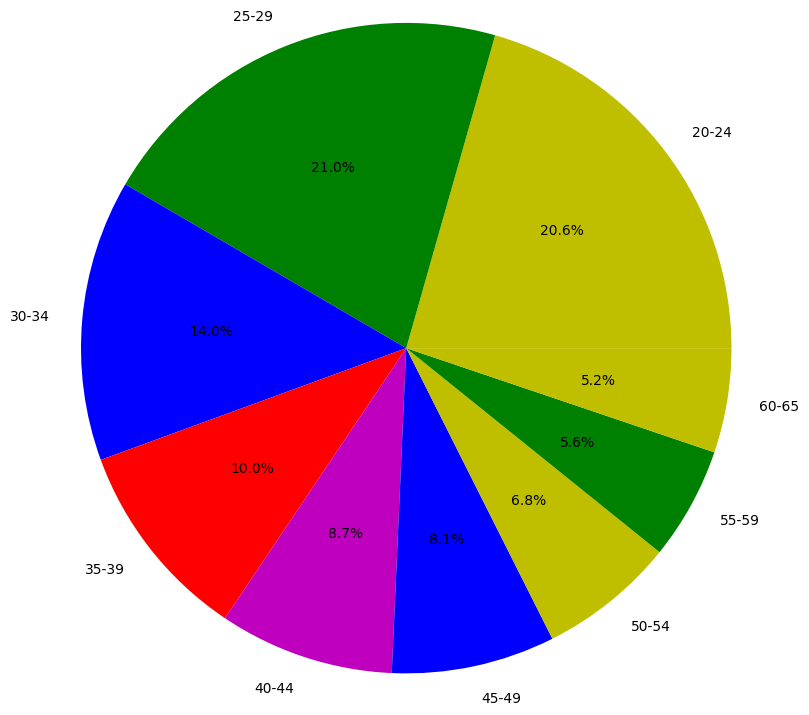

In [27]:
#visualize group wise data distribution

age = [x,y,z,a,b,c,d,e,f]
labels = ['20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-65']
colors = [ 'y', 'g','b','r','m','b','y','g']
plt.pie(age,labels = labels,colors = colors,radius=2.2,autopct='%.1f%%')
plt.show()

## Image Data Generator

Image Data Generator is used to artificially expand a dataset by creating modified versions of images or other data points.It is a powerful technique that can help improve the performance, generalization, and robustness of machine learning models

**Note: Only augment images in train set. Validation/test set images must not be augmented.**

In [28]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [29]:
df['ageclass'] = df['ageclass'].astype(str)
df

,age,gender,path,full_path,ageclass
0,39,male,4256472_1974-08-10_2014.jpg,/content/drive/MyDrive/Rachana/cropped_faces/4...,3
1,44,female,705751_1968-02-12_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/7...,4
3,52,male,3649107_1957-11-07_2010.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,6
4,33,female,1421957_1973-12-05_2007.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...,2
5,29,female,33235439_1983-05-08_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,1
...,...,...,...,...,...
62318,25,male,14539522_1982-05-26_2008.jpg,/content/drive/MyDrive/Rachana/cropped_faces/1...,1
62320,23,male,31219748_1989-09-04_2013.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,0
62323,31,female,30408996_1977-06-25_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/3...,2
62326,25,male,21547067_1983-09-18_2009.jpg,/content/drive/MyDrive/Rachana/cropped_faces/2...,1


In [30]:
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Create an ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='full_path',  # Assuming 'cropped_face_path' is the column containing the paths to cropped faces
    y_col='ageclass',
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Flow from DataFrame for testing
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='full_path',
    y_col='ageclass',
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Check the sizes of the datasets
print("Train set size:", len(train))
print("Test set size:", len(test))
print("train_generator: ", len(train_generator))
print("test_generator: ", len(test_generator))

/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3587 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 19810 validated image filenames belonging to 9 classes.
Found 4965 validated image filenames belonging to 9 classes.
Train set size: 23397
Test set size: 5850
train_generator:  310
test_generator:  78


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 885 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


In [31]:
# Check the size of the original training set
print("Original train set size:", len(train))


# number of batches (len(train_generator)) multiplied by the batch size (train_generator.batch_size).
#The train_generator generates augmented images on-the-fly, so the number of samples in the
#augmented training set is essentially the number of batches multiplied by the batch size.
# Calculate the size of the augmented training set
augmented_train_size = len(train_generator) * train_generator.batch_size
print("Augmented train set size:", augmented_train_size)


Original train set size: 23397
Augmented train set size: 19840


In [32]:
# Check the size of the original training set
print("Original test set size:", len(test ))

# Calculate the size of the augmented training set
augmented_test_size = len(test_generator) * test_generator.batch_size
print("Augmented test set size:", augmented_test_size)


Original test set size: 5850
Augmented test set size: 4992


## Model Architecture

Age estimation is a classification problem in our case as we have devided the numbers in 9 classes, but if there is number as one class then its regression problem

### Define the Model

In [33]:
model = models.Sequential([
    layers.Conv2D(64,   (3, 3), activation='relu', input_shape=(180, 180, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, kernel_regularizer=l2(0.01),activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, kernel_regularizer=l2(0.01), activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])


NameError: name 'models' is not defined

### Compile the Model

In [ ]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# convert class labels to on-hot encoding# conve
from keras.utils import to_categorical
Y = to_categorical(np.array(df['ageclass']) ,9)

### Train the Model

In [79]:
# from keras import callbacks
# filepath="/content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5"
# # Creating a TensorBoard callback object and saving it at the desired location.

# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [80]:
# # Train the model
# history = model.fit(train_generator,
#     batch_size=64,
#     epochs=100,
#     validation_data=test_generator,
#     callbacks=[checkpoint]
# )


2024/03/12 18:35:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4910a7b2672e40499277feb22865b454', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/12 18:36:00 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras_preprocessing.image.dataframe_iterator.DataFrameIterator'>. Dataset logging skipped.
2024/03/12 18:36:00 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras_preprocessing.image.dataframe_iterator.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/100
310/310 [==============================] - ETA: 0s - loss: 5.1390 - accuracy: 0.1943 


Epoch 1: val_loss improved from inf to 3.03487, saving model to /content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 5571s 18s/step - loss: 5.1390 - accuracy: 0.1943 - val_loss: 3.0349 - val_accuracy: 0.2050
Epoch 2/100
310/310 [==============================] - ETA: 0s - loss: 2.4292 - accuracy: 0.2184
Epoch 2: val_loss improved from 3.03487 to 2.26947, saving model to /content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5
310/310 [==============================] - 262s 843ms/step - loss: 2.4292 - accuracy: 0.2184 - val_loss: 2.2695 - val_accuracy: 0.1766
Epoch 3/100
310/310 [==============================] - ETA: 0s - loss: 2.0553 - accuracy: 0.2319
Epoch 3: val_loss improved from 2.26947 to 2.00914, saving model to /content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5
310/310 [==============================] - 257s 827ms/step - loss: 2.0553 - accuracy: 0.2319 - val_loss: 2.0091 - val_accuracy: 0.2308
Epoch 4/100
310/310 [==============================] - ETA: 0s - loss: 1.9812 - accuracy: 0.2326
Epoch 4

310/310 [==============================] - 255s 824ms/step - loss: 1.7154 - accuracy: 0.2997 - val_loss: 1.7160 - val_accuracy: 0.2896
Epoch 20/100
310/310 [==============================] - ETA: 0s - loss: 1.7088 - accuracy: 0.3054
Epoch 20: val_loss improved from 1.71602 to 1.68378, saving model to /content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5
310/310 [==============================] - 250s 808ms/step - loss: 1.7088 - accuracy: 0.3054 - val_loss: 1.6838 - val_accuracy: 0.3039
Epoch 21/100
310/310 [==============================] - ETA: 0s - loss: 1.6997 - accuracy: 0.3038
Epoch 21: val_loss did not improve from 1.68378
310/310 [==============================] - 253s 815ms/step - loss: 1.6997 - accuracy: 0.3038 - val_loss: 1.8388 - val_accuracy: 0.2530
Epoch 22/100
310/310 [==============================] - ETA: 0s - loss: 1.6853 - accuracy: 0.3095
Epoch 22: val_loss improved from 1.68378 to 1.67317, saving model to /content/drive/MyDrive/Rachana/mod

310/310 [==============================] - 252s 812ms/step - loss: 1.5673 - accuracy: 0.3506 - val_loss: 1.6568 - val_accuracy: 0.3217
Epoch 46/100
310/310 [==============================] - ETA: 0s - loss: 1.5620 - accuracy: 0.3521
Epoch 46: val_loss improved from 1.63760 to 1.62818, saving model to /content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5
310/310 [==============================] - 251s 808ms/step - loss: 1.5620 - accuracy: 0.3521 - val_loss: 1.6282 - val_accuracy: 0.3410
Epoch 47/100
310/310 [==============================] - ETA: 0s - loss: 1.5474 - accuracy: 0.3607
Epoch 47: val_loss did not improve from 1.62818
310/310 [==============================] - 251s 810ms/step - loss: 1.5474 - accuracy: 0.3607 - val_loss: 1.6628 - val_accuracy: 0.3353
Epoch 48/100
310/310 [==============================] - ETA: 0s - loss: 1.5425 - accuracy: 0.3566
Epoch 48: val_loss did not improve from 1.62818
310/310 [==============================] - 252s 814ms/s

310/310 [==============================] - 252s 811ms/step - loss: 1.4415 - accuracy: 0.3990 - val_loss: 1.7008 - val_accuracy: 0.3394
Epoch 77/100
310/310 [==============================] - ETA: 0s - loss: 1.4334 - accuracy: 0.3999
Epoch 77: val_loss did not improve from 1.62818
310/310 [==============================] - 252s 812ms/step - loss: 1.4334 - accuracy: 0.3999 - val_loss: 1.6735 - val_accuracy: 0.3498
Epoch 78/100
310/310 [==============================] - ETA: 0s - loss: 1.4260 - accuracy: 0.4043
Epoch 78: val_loss did not improve from 1.62818
310/310 [==============================] - 247s 798ms/step - loss: 1.4260 - accuracy: 0.4043 - val_loss: 1.7087 - val_accuracy: 0.3557
Epoch 79/100
310/310 [==============================] - ETA: 0s - loss: 1.4252 - accuracy: 0.4055
Epoch 79: val_loss did not improve from 1.62818
310/310 [==============================] - 245s 790ms/step - loss: 1.4252 - accuracy: 0.4055 - val_loss: 1.6797 - val_accuracy: 0.3464
Epoch 80/100
310/310 [

310/310 [==============================] - 247s 797ms/step - loss: 1.3600 - accuracy: 0.4340 - val_loss: 1.7451 - val_accuracy: 0.3476


2024/03/13 03:11:19 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/03/13 03:11:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/03/13 03:11:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
# Saving the model as a h5 file for possible use later.

model.save(f"/content/drive/MyDrive/models/age_estimation_v4_MLFlow.h5", save_format='h5')

In [ ]:
# # Train the model
# history2 = model.fit(train_generator,
#     batch_size=64,
#     epochs=100,
#     validation_data=test_generator,
#     callbacks=[checkpoint]
# )


2024/03/13 04:06:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ece39d26fb8246b2b16ec4c6a6bc6a68', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/13 04:06:22 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras_preprocessing.image.dataframe_iterator.DataFrameIterator'>. Dataset logging skipped.
2024/03/13 04:06:22 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras_preprocessing.image.dataframe_iterator.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/100
310/310 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.4318
Epoch 1: val_loss did not improve from 1.62818


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 257s 828ms/step - loss: 1.3541 - accuracy: 0.4318 - val_loss: 1.8658 - val_accuracy: 0.3388
Epoch 2/100
310/310 [==============================] - ETA: 0s - loss: 1.3514 - accuracy: 0.4295
Epoch 2: val_loss did not improve from 1.62818
310/310 [==============================] - 253s 815ms/step - loss: 1.3514 - accuracy: 0.4295 - val_loss: 1.8603 - val_accuracy: 0.3329
Epoch 3/100
310/310 [==============================] - ETA: 0s - loss: 1.3487 - accuracy: 0.4387
Epoch 3: val_loss did not improve from 1.62818
310/310 [==============================] - 252s 812ms/step - loss: 1.3487 - accuracy: 0.4387 - val_loss: 1.8288 - val_accuracy: 0.3537
Epoch 4/100
310/310 [==============================] - ETA: 0s - loss: 1.3556 - accuracy: 0.4375
Epoch 4: val_loss did not improve from 1.62818
310/310 [==============================] - 252s 811ms/step - loss: 1.3556 - accuracy: 0.4375 - val_loss: 1.7799 - val_accuracy: 0.3531
Epoch 5/100
310/310 [=======

310/310 [==============================] - 247s 795ms/step - loss: 1.2939 - accuracy: 0.4558 - val_loss: 1.8625 - val_accuracy: 0.3450
Epoch 23/100
310/310 [==============================] - ETA: 0s - loss: 1.2858 - accuracy: 0.4559
Epoch 23: val_loss did not improve from 1.62818
310/310 [==============================] - 245s 790ms/step - loss: 1.2858 - accuracy: 0.4559 - val_loss: 1.8731 - val_accuracy: 0.3251
Epoch 24/100
310/310 [==============================] - ETA: 0s - loss: 1.2967 - accuracy: 0.4590
Epoch 24: val_loss did not improve from 1.62818
310/310 [==============================] - 245s 789ms/step - loss: 1.2967 - accuracy: 0.4590 - val_loss: 1.9011 - val_accuracy: 0.3116
Epoch 25/100
310/310 [==============================] - ETA: 0s - loss: 1.2813 - accuracy: 0.4680
Epoch 25: val_loss did not improve from 1.62818
310/310 [==============================] - 251s 809ms/step - loss: 1.2813 - accuracy: 0.4680 - val_loss: 1.9098 - val_accuracy: 0.3452
Epoch 26/100
310/310 [

310/310 [==============================] - 250s 807ms/step - loss: 1.2836 - accuracy: 0.4546 - val_loss: 1.8871 - val_accuracy: 0.3217
Epoch 27/100
310/310 [==============================] - ETA: 0s - loss: 1.2790 - accuracy: 0.4648
Epoch 27: val_loss did not improve from 1.62818
310/310 [==============================] - 247s 796ms/step - loss: 1.2790 - accuracy: 0.4648 - val_loss: 1.9547 - val_accuracy: 0.3372
Epoch 28/100
310/310 [==============================] - ETA: 0s - loss: 1.2791 - accuracy: 0.4694
Epoch 28: val_loss did not improve from 1.62818
310/310 [==============================] - 250s 805ms/step - loss: 1.2791 - accuracy: 0.4694 - val_loss: 1.8438 - val_accuracy: 0.3360
Epoch 29/100
310/310 [==============================] - ETA: 0s - loss: 1.2805 - accuracy: 0.4626
Epoch 29: val_loss did not improve from 1.62818
310/310 [==============================] - 253s 815ms/step - loss: 1.2805 - accuracy: 0.4626 - val_loss: 1.7867 - val_accuracy: 0.3446
Epoch 30/100
310/310 [

310/310 [==============================] - 250s 807ms/step - loss: 1.2515 - accuracy: 0.4797 - val_loss: 1.9319 - val_accuracy: 0.3325
Epoch 40/100
310/310 [==============================] - ETA: 0s - loss: 1.2479 - accuracy: 0.4814
Epoch 40: val_loss did not improve from 1.62818
310/310 [==============================] - 249s 803ms/step - loss: 1.2479 - accuracy: 0.4814 - val_loss: 1.9625 - val_accuracy: 0.3412
Epoch 41/100
310/310 [==============================] - ETA: 0s - loss: 1.2547 - accuracy: 0.4825
Epoch 41: val_loss did not improve from 1.62818
310/310 [==============================] - 247s 796ms/step - loss: 1.2547 - accuracy: 0.4825 - val_loss: 1.8894 - val_accuracy: 0.3519
Epoch 42/100
310/310 [==============================] - ETA: 0s - loss: 1.2486 - accuracy: 0.4804
Epoch 42: val_loss did not improve from 1.62818
310/310 [==============================] - 247s 796ms/step - loss: 1.2486 - accuracy: 0.4804 - val_loss: 1.9666 - val_accuracy: 0.3243
Epoch 43/100
310/310 [

310/310 [==============================] - 248s 799ms/step - loss: 1.2389 - accuracy: 0.4845 - val_loss: 2.0002 - val_accuracy: 0.3146
Epoch 47/100
310/310 [==============================] - ETA: 0s - loss: 1.2403 - accuracy: 0.4843
Epoch 47: val_loss did not improve from 1.62818
310/310 [==============================] - 249s 803ms/step - loss: 1.2403 - accuracy: 0.4843 - val_loss: 1.9891 - val_accuracy: 0.3486
Epoch 48/100
310/310 [==============================] - ETA: 0s - loss: 1.2330 - accuracy: 0.4911
Epoch 48: val_loss did not improve from 1.62818
310/310 [==============================] - 251s 808ms/step - loss: 1.2330 - accuracy: 0.4911 - val_loss: 1.9731 - val_accuracy: 0.3450
Epoch 49/100
310/310 [==============================] - ETA: 0s - loss: 1.2224 - accuracy: 0.4908
Epoch 49: val_loss did not improve from 1.62818
310/310 [==============================] - 246s 793ms/step - loss: 1.2224 - accuracy: 0.4908 - val_loss: 2.0132 - val_accuracy: 0.3287
Epoch 50/100
310/310 [

310/310 [==============================] - 246s 793ms/step - loss: 1.2113 - accuracy: 0.5025 - val_loss: 2.0536 - val_accuracy: 0.3313
Epoch 58/100
310/310 [==============================] - ETA: 0s - loss: 1.2037 - accuracy: 0.4978
Epoch 58: val_loss did not improve from 1.62818
310/310 [==============================] - 249s 803ms/step - loss: 1.2037 - accuracy: 0.4978 - val_loss: 1.9805 - val_accuracy: 0.3416
Epoch 59/100
310/310 [==============================] - ETA: 0s - loss: 1.2110 - accuracy: 0.4965
Epoch 59: val_loss did not improve from 1.62818
310/310 [==============================] - 248s 801ms/step - loss: 1.2110 - accuracy: 0.4965 - val_loss: 1.9752 - val_accuracy: 0.3281
Epoch 60/100
310/310 [==============================] - ETA: 0s - loss: 1.2064 - accuracy: 0.5010
Epoch 60: val_loss did not improve from 1.62818
310/310 [==============================] - 250s 806ms/step - loss: 1.2064 - accuracy: 0.5010 - val_loss: 2.0492 - val_accuracy: 0.3210
Epoch 61/100
310/310 [

310/310 [==============================] - 253s 817ms/step - loss: 1.1955 - accuracy: 0.5110 - val_loss: 2.0524 - val_accuracy: 0.3400
Epoch 66/100
310/310 [==============================] - ETA: 0s - loss: 1.1852 - accuracy: 0.5145
Epoch 66: val_loss did not improve from 1.62818
310/310 [==============================] - 246s 795ms/step - loss: 1.1852 - accuracy: 0.5145 - val_loss: 2.0963 - val_accuracy: 0.3519
Epoch 67/100
310/310 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.5184
Epoch 67: val_loss did not improve from 1.62818
310/310 [==============================] - 255s 822ms/step - loss: 1.1869 - accuracy: 0.5184 - val_loss: 2.0252 - val_accuracy: 0.3388
Epoch 68/100
310/310 [==============================] - ETA: 0s - loss: 1.1867 - accuracy: 0.5079
Epoch 68: val_loss did not improve from 1.62818
310/310 [==============================] - 253s 816ms/step - loss: 1.1867 - accuracy: 0.5079 - val_loss: 2.0026 - val_accuracy: 0.3498
Epoch 69/100
310/310 [

310/310 [==============================] - 251s 811ms/step - loss: 1.1767 - accuracy: 0.5204 - val_loss: 2.1574 - val_accuracy: 0.3303
Epoch 79/100
310/310 [==============================] - ETA: 0s - loss: 1.1692 - accuracy: 0.5225
Epoch 79: val_loss did not improve from 1.62818
310/310 [==============================] - 250s 805ms/step - loss: 1.1692 - accuracy: 0.5225 - val_loss: 2.0671 - val_accuracy: 0.3358
Epoch 80/100
310/310 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.5174
Epoch 80: val_loss did not improve from 1.62818
310/310 [==============================] - 245s 790ms/step - loss: 1.1672 - accuracy: 0.5174 - val_loss: 2.1390 - val_accuracy: 0.3329
Epoch 81/100
310/310 [==============================] - ETA: 0s - loss: 1.1571 - accuracy: 0.5208
Epoch 81: val_loss did not improve from 1.62818
310/310 [==============================] - 249s 804ms/step - loss: 1.1571 - accuracy: 0.5208 - val_loss: 2.2643 - val_accuracy: 0.3353
Epoch 82/100
310/310 [

In [34]:
from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5')
filepath='/content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss_200.h5'
from keras import callbacks
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# from keras import callbacks
# filepath="/content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5"
# # Creating a TensorBoard callback object and saving it at the desired location.

# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [35]:
loaded_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history3 = loaded_model.fit(train_generator,
    batch_size=64,
    epochs=50,
    validation_data=test_generator,
    callbacks=[checkpoint]
)


2024/03/13 10:24:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd7ce3c58b5054c62a30bc8ecf9bc27e3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/13 10:25:11 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras_preprocessing.image.dataframe_iterator.DataFrameIterator'>. Dataset logging skipped.
2024/03/13 10:25:11 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras_preprocessing.image.dataframe_iterator.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/50
  6/310 [..............................] - ETA: 1:56:21 - loss: 1.4696 - accuracy: 0.3828

In [ ]:
# Saving the model as a h5 file for possible use later.

loaded_model.save(f"/content/drive/MyDrive/models/age_estimation_v4_MLFlow200_history3.h5", save_format='h5')

### Evalaute the Trained Model

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = history3.history['loss']
test_loss = history3.history['val_loss']
train_accuracy = history3.history['accuracy']
test_accuracy = history3.history['val_accuracy']

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/MyDrive/models/age_estimation_v4_MLFlow_loss_accuracy.png', bbox_inches='tight');

In [ ]:

# Evaluate the model
test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

# Get predictions
y_pred = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

In [ ]:
# See your experiments table inside Colab!
import IPython
display(IPython.display.IFrame("https://dagshub.com/"+ os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + "/experiments/#/",'100%',600))

## Age Estimation based on Provided Image

In [ ]:
new_model = load_model('/content/drive/MyDrive/Rachana/model/mlflow/age_estimation_v4_mlflow_min_loss.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from mtcnn import MTCNN

def load_and_preprocess_image(filepath):
    test_img = image.load_img(filepath, target_size=(198, 198))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img /= 255
    return test_img

def detect_and_crop_face(image_path):
    img = cv2.imread(image_path)
    detector = MTCNN()
    result = detector.detect_faces(img)
    #print('result',result)
    if len(result) == 1 and result[0]['confidence'] > 0.98:
        x, y, w, h = result[0]['box']
        cropped_img = img[y:y+h, x:x+w]
        #print('cropped_img',cropped_img)
        return cropped_img
    else:
        return None



def predict_age_from_image(image_path, model):
    cropped_img = detect_and_crop_face(image_path)
    prb_age = []  # Initialize prb_age here
    if cropped_img is not None:
        age_pred = model.predict(load_and_preprocess_image(image_path))
        age_pred_rounded = [round(prob, 2) for prob in age_pred[0]]
        age_classes = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-65']
        max_prob_index = np.argmax(age_pred[0])
        max_age_class = age_classes[max_prob_index]

        plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
        plt.show()

        # print("Probabilities :", age_classes)
        # print("Probabilities :", age_pred_rounded)
        # print(f'Most probable age group: {max_age_class}')

        # Print predicted age probabilities
        for i, prob in enumerate(age_pred_rounded):
            prb_age.append(f"{age_classes[i]} years old: {prob:.4f}")



        # Get the index of the maximum probability
        max_age_index = np.argmax(age_pred)

        # Print predicted age
        predicted_age = age_classes[max_age_index]

        #print('Predicted Age i: ', predicted_age ,'Probabilities i :',prb_age)
    else:
        predicted_age= ("No face detected or Multiple faces detected in the image, Please upload an image with one human face!")

    print('Predicted Age : ', predicted_age  ,'\nProbabilities :',prb_age)

#uploade image

picture = "/Users/rachana/Documents/age_detection_Final/Images/MicrosoftTeams-image (14) 2.png"
predict_age_from_image(picture,new_model)
